In [1]:
import torch
from torch import optim,nn
from torchvision import datasets,transforms as T,models
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.utils.data.sampler import SubsetRandomSampler
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as pltmg
from collections import OrderedDict
import sklearn
import os
import cv2

In [2]:
full_train_df = pd.read_csv("train/train_labels.csv")
full_train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [3]:
SAMPLE_SIZE = 80000

train_path = 'train/'
test_path = 'test/'

df_negatives = full_train_df[full_train_df['label'] == 0].sample(SAMPLE_SIZE, random_state=42)
df_positives = full_train_df[full_train_df['label'] == 1].sample(SAMPLE_SIZE, random_state=42)

train_df = sklearn.utils.shuffle(pd.concat([df_positives, df_negatives], axis=0).reset_index(drop=True))

train_df.shape

(160000, 2)

In [4]:
class Data(torch.utils.data.Dataset):
    def __init__(self,df_data,root_dir,transform=None):
        self.labels =  df_data.values
        self.images = root_dir
        self.transform = transform
    def __len__(self):
         return len(self.labels)
    def __getitem__(self,idx):
        img_name,label = self.labels[idx]
        img_path = os.path.join(self.images, img_name+'.tif')
        image = cv2.imread(img_path)
        if self.transform is not None:
            image = self.transform(image)
        return image, label

In [5]:
train_transform = T.Compose([
    T.ToPILImage(),
    T.Resize(224),
    T.RandomHorizontalFlip(p=0.4),
    T.RandomVerticalFlip(p=0.4),
    T.RandomRotation(20),
    T.ToTensor(),
    T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

In [6]:
Train_data = Data(df_data = train_df,root_dir = 'train/',transform = train_transform)

In [7]:
valid_size = 0.15
indicies = len(Train_data)
r = list(range(indicies))
np.random.shuffle(r)
split = int(np.floor(valid_size * indicies))
train_idx, valid_idx = r[split:],r[:split]

In [8]:
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [9]:
Train_loader = DataLoader(Train_data, batch_size = 120,sampler = train_sampler)
Valid_loader = DataLoader(Train_data, batch_size = 120, sampler = valid_sampler)

In [10]:
dataiter = iter(Train_loader)
images,labels = dataiter.next()
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([120, 3, 224, 224])
torch.Size([120])


In [11]:
def imshow(image):
    image = image.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    image = np.clip(image, 0, 1)
    plt.imshow(image) 

classes = ['Bengin','Malignant']

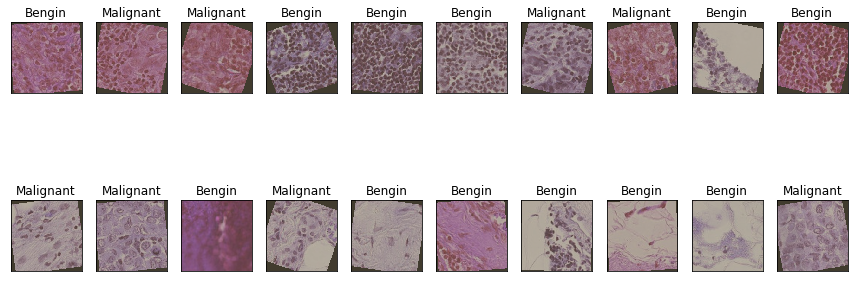

In [12]:
fig = plt.figure(figsize=(15, 6))
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [186]:
model = models.resnet101(pretrained=True)
for i, param in model.named_parameters():
    param.requires_grad = False


fc = nn.Sequential(OrderedDict([
    ('fc1',nn.Linear(2048,1024)),
    ('relu',nn.ReLU()),
    ('dropout',nn.Dropout(0.3)),
    ('fc2',nn.Linear(1024,500)),
    ('relu',nn.ReLU()),
    ('dropout',nn.Dropout(0.3)),
    ('fc3',nn.Linear(500,2))
    
]))

model.fc = fc
model.cuda()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [193]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [194]:
epochs = 20

In [ ]:
train_loss_data = []
val_loss_data = []

for i in range(epochs):

    train_loss = 0
    val_loss = 0
    train_run = 0

    

    model.train()
  
    for images, labels in Train_loader:
        images = images.cuda()
        labels = labels.cuda()
        
        logps = model(images)
        optimizer.zero_grad()
        loss = criterion(logps,labels)
        loss.backward()
        optimizer.step()
        
        train_run += loss.item()
        train_loss += loss.item()*images.size(0)

       
        
    
    model.eval()
    for images,labels in Valid_loader:
        
        images = images.cuda()
        labels = labels.cuda()

        logps = model(images)
        loss = criterion(logps,labels)
        val_loss += loss.item()*images.size(0)

     

    train_loss = train_loss/len(Train_loader.sampler)
    val_loss = val_loss/len(Valid_loader.sampler)
  

    train_loss_data.append(train_loss)
    val_loss_data.append(val_loss)
   

    print("Epoch : {} training Loss : {:.6f} Validation Loss : {:.6f} ".format(i+1,train_loss,val_loss))
